Эти датасеты компании Самокат я нашел в интернете. Предствалю, что у меня нет рамок и четких задач, просто покажу свои скиллы в питоне и умении мыслить аналитически.

# **Импорт библиотек**


In [1]:
import pandas as pd
import numpy as np
import encodings
import matplotlib.pyplot as plt
import seaborn as sns

# **Импорт файлов**

In [2]:
orders = pd.read_csv('/content/orders.csv')
orders_lines = pd.read_csv('/content/order_lines.txt',delimiter='\t')
products = pd.read_csv('/content/products.csv',encoding='maccyrillic')
warehouses = pd.read_csv('/content/warehouses.csv')

<ipython-input-2-763f4aa8ff60>:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  orders = pd.read_csv('/content/orders.csv')
<ipython-input-2-763f4aa8ff60>:2: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  orders_lines = pd.read_csv('/content/order_lines.txt',delimiter='\t')


Таблица orders - содержит данные о заказах.

In [3]:
orders.head()

,order_date,order_id,warehouse_id,user_id
0,2017-08-01,910381,38,11473
1,2017-08-01,918510,276,52410
2,2017-08-01,909015,208,10155
3,2017-08-01,915064,2,60635
4,2017-08-01,914110,38,17185


In [4]:
orders.shape

(269271, 4)

In [5]:
orders.info()
orders.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269271 entries, 0 to 269270
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   order_date    269271 non-null  object
 1   order_id      269271 non-null  int64 
 2   warehouse_id  269271 non-null  int64 
 3   user_id       269271 non-null  object
dtypes: int64(2), object(2)
memory usage: 8.2+ MB


,order_id,warehouse_id
count,2.692710e+05,269271.000000
mean,1.041835e+06,180.419633
std,8.139378e+04,204.438992
min,4.777200e+04,1.000000
25%,9.745755e+05,38.000000
50%,1.041904e+06,109.000000
75%,1.109686e+06,264.000000
max,1.202488e+06,1339.000000


Странно, что user_id - object. Возьму на заметку.


In [6]:
orders.nunique()

,0
order_date,30
order_id,269206
warehouse_id,80
user_id,103485


По идее у нас должны храниться только уникальные заказы, но можно заметить у нас уникальных order_id - 269206, а в таблице все order_id - 269271, скорее всего есть дубликаты. Разница - 65

In [7]:
do = orders[orders.duplicated()]

In [8]:
do

,order_date,order_id,warehouse_id,user_id
220922,2017-08-25,1113894,29,65190
220923,2017-08-25,1130347,98,11575
220924,2017-08-25,1119756,54,48264
220925,2017-08-25,1124022,330,62879
220926,2017-08-25,1139773,38,754
...,...,...,...,...
220982,2017-08-25,1126485,103,74047
220983,2017-08-25,1114494,144,87430
220984,2017-08-25,1133886,174,50218
220985,2017-08-25,1128021,35,72034


Видим, что в таблице orders у нас есть дубликаты, как раз 65 шт. К сожалению, это только учебный проект и нельзя сказать как и откуда у нас они появились.

In [9]:
orders = orders.drop_duplicates()

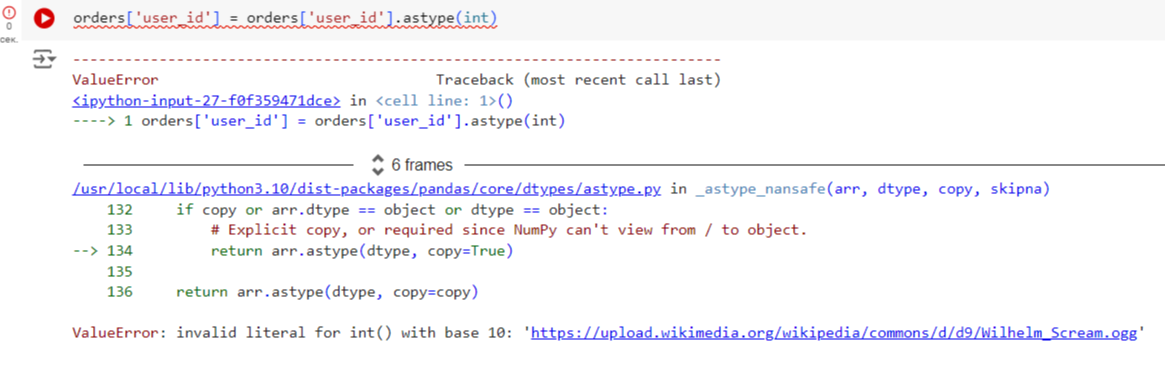

Видимо не все записи в столбце user_id - являются числами.

In [10]:
orders[orders['user_id'].astype(str).str.contains('[a-zA-Z]')]

,order_date,order_id,warehouse_id,user_id
213739,2017-08-25,1132541,2,https://upload.wikimedia.org/wikipedia/commons...


In [11]:
orders.loc[orders['user_id'].astype(str).str.contains('[a-zA-Z]'), 'user_id'] = 0

Так как у меня нет четких инструкций, просто поменяю эту непонятную сслылку на 0.

In [12]:
orders['user_id'] = orders['user_id'].astype(int)

In [13]:
orders.describe()

,order_id,warehouse_id,user_id
count,2.692060e+05,269206.000000,2.692060e+05
mean,1.041817e+06,180.417762,2.393839e+05
std,8.138051e+04,204.437470,2.819679e+05
min,4.777200e+04,1.000000,-2.754540e+05
25%,9.745602e+05,38.000000,7.943700e+04
50%,1.041872e+06,109.000000,2.004440e+05
75%,1.109639e+06,264.000000,2.791990e+05
max,1.202488e+06,1339.000000,1.891385e+06


Странно, что в столбце user_id есть значения меньше 0.

In [14]:
orders[orders.user_id<0]

,order_date,order_id,warehouse_id,user_id
167782,2017-08-20,1072397,508,-275454


Посмотрим, возможно как-то случайно минус образовался, есть ли такой id только без минуса.

In [15]:
orders[orders.user_id == 275454]

,order_date,order_id,warehouse_id,user_id
11874,2017-08-02,907776,508,275454
167778,2017-08-20,1085122,508,275454
262415,2017-08-30,1168378,508,275454


Да, есть такой id, только без знака минус, так же совпадает warehouse_id, поэтому с большой вероятностью - это 275454.

In [16]:
orders.loc[orders['user_id']<0, 'user_id'] = orders['user_id']*-1

Так как нет четких инструкций, просто умножу на -1.

**orders_lines**

Таблица orders_lines - содержит id товаров которые содержатся в заказах.

In [17]:
orders_lines.head()

,order_id,product_id,price,quantity
0,47772,1929,110.25,1
1,47772,3785,16.5,1
2,47772,3967,39.0,1
3,47772,5837,36.75,1
4,56496,2591,171.75,1


In [18]:
orders_lines.info()
orders_lines.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 975171 entries, 0 to 975170
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   order_id    975171 non-null  int64 
 1   product_id  975171 non-null  object
 2   price       975171 non-null  object
 3   quantity    975171 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 29.8+ MB


,order_id,quantity
count,9.751710e+05,975171.000000
mean,1.027467e+06,1.164843
std,7.334799e+04,0.816467
min,4.777200e+04,1.000000
25%,9.677775e+05,1.000000
50%,1.028466e+06,1.000000
75%,1.088594e+06,1.000000
max,1.149999e+06,42.000000


По идее pricе должен быть float и  product_id - int, а мы видим object.

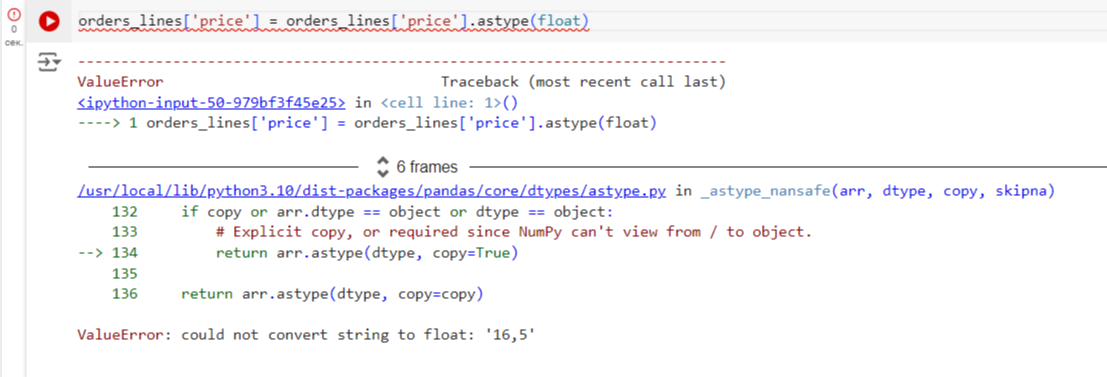

По ошибке видим, что есть как миним 1 запись, которая вместо разделителя в виде точки содержит запятую.

In [19]:
orders_lines['price'] = orders_lines['price'].astype(str).str.replace(",", "").astype(float)

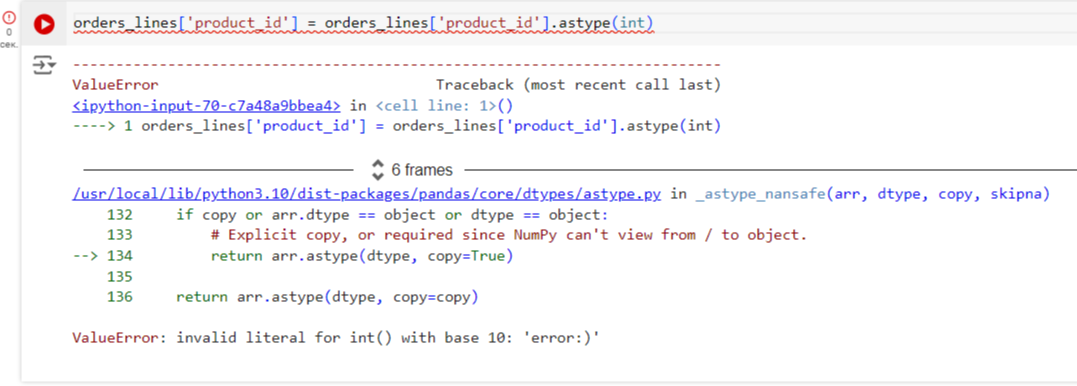

По ошибки видим, что в столбце product_id содержится несоотвествующие значение.

In [20]:
orders_lines['price'] = orders_lines['price'].astype(str).str.replace(",", "").astype(float)

In [21]:
orders_lines[orders_lines['product_id'].str.contains('[a-zA-Z]', na=False)]

,order_id,product_id,price,quantity
397378,1006273,error:),112.5,1


In [22]:
orders_lines['product_id'] = orders_lines['product_id'].replace('error:)', '0')

Просто заменим его на 0.

In [23]:
orders_lines['product_id'] = orders_lines['product_id'].astype(int)

In [24]:
orders_lines.describe()

,order_id,product_id,price,quantity
count,9.751710e+05,975171.000000,975171.000000,975171.000000
mean,1.027467e+06,5411.414110,63.711036,1.164843
std,7.334799e+04,4166.521002,55.500661,0.816467
min,4.777200e+04,0.000000,5.250000,1.000000
25%,9.677775e+05,2194.000000,33.000000,1.000000
50%,1.028466e+06,4457.000000,51.750000,1.000000
75%,1.088594e+06,7552.000000,75.750000,1.000000
max,1.149999e+06,22430.000000,2242.500000,42.000000


In [25]:
orders_lines[orders_lines.duplicated()]

,order_id,product_id,price,quantity
975106,56496,10135,29.25,1
975107,60135,3950,39.75,1
975108,60135,5284,117.00,1
975109,60135,5825,21.75,1
975110,60135,12770,96.75,1
...,...,...,...,...
975166,228485,1993,179.25,1
975167,228485,2334,71.25,1
975168,228485,2738,66.75,1
975169,228485,2928,96.75,1


В этой таблице тоже возникли дубликаты, которые повторяют часть заказа или его полностью. Причем эти дубликаты являются последними 65 записями в таблице. К сожалению, нельзя понять почему это произошло.

In [26]:
orders_lines.tail(65)

,order_id,product_id,price,quantity
975106,56496,10135,29.25,1
975107,60135,3950,39.75,1
975108,60135,5284,117.00,1
975109,60135,5825,21.75,1
975110,60135,12770,96.75,1
...,...,...,...,...
975166,228485,1993,179.25,1
975167,228485,2334,71.25,1
975168,228485,2738,66.75,1
975169,228485,2928,96.75,1


**products**

In [27]:
products.head()

,product_id,product,category
0,8,"Мороженое Коровка из Кореновки пломбир, ваниль...",Замороженная продукция
1,9,"Мороженое Коровка из Кореновки пломбир, шокола...",Замороженная продукция
2,12,"Мороженое Коровка из Кореновки пломбир, крем-б...",Замороженная продукция
3,16,"Мороженое Коровка из Кореновки пломбир, шокола...",Замороженная продукция
4,22,"Мороженое Коровка из Кореновки пломбир, двухсл...",Замороженная продукция


In [28]:
products.info()
products.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1740 entries, 0 to 1739
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   product_id  1740 non-null   int64 
 1   product     1740 non-null   object
 2   category    1740 non-null   object
dtypes: int64(1), object(2)
memory usage: 40.9+ KB


,product_id
count,1740.000000
mean,5458.190805
std,4214.714605
min,8.000000
25%,2170.500000
50%,4586.000000
75%,7598.250000
max,22250.000000


In [29]:
products[products.duplicated()]

,product_id,product,category
1725,3470,Масло подсолнечное Лея рафинированное дезодори...,Бакалея
1726,3472,"Напиток Mirinda с апельсином, газированный, 1 л",Безалкогольные напитки
1727,3473,Зубная паста Blend-a-Med Pro-Expert свежая мят...,Уход и гигиена
1728,3475,"Напиток Любимый апельсин-манго-мандарин, 950 мл",Безалкогольные напитки
1729,3484,"Паста ореховая Nutella с добавлением какао, 180 г",Кондитерские изделия
1730,3486,"Йогурт Греческий АйсКро клубника-базилик, 3%, ...",Молочная продукция
1731,3501,"Томаты Выборжец коктейльный микс, красные и же...",Свежие овощи
1732,3510,"Лакомство Dreamies для кошек, с говядиной, 60 г",Продукция для животных
1733,3519,"Напиток Fanta (США) Apple, газированный, 355 мл",Безалкогольные напитки
1734,3527,"Напиток Fanta (США) Grape, газированный, 355 мл",Безалкогольные напитки


In [30]:
products = products.drop_duplicates()

In [31]:
products.shape

(1725, 3)

# **Основная часть**

In [32]:
df = orders.merge(orders_lines, on='order_id', how='outer')

In [33]:
df.head()

,order_date,order_id,warehouse_id,user_id,product_id,price,quantity
0,2017-08-01,910381,38.0,11473.0,5570.0,44.25,1.0
1,2017-08-01,918510,276.0,52410.0,9845.0,54.00,1.0
2,2017-08-01,918510,276.0,52410.0,19071.0,44.25,1.0
3,2017-08-01,909015,208.0,10155.0,451.0,83.25,1.0
4,2017-08-01,915064,2.0,60635.0,1054.0,69.75,1.0


In [34]:
df.dtypes

,0
order_date,object
order_id,int64
warehouse_id,float64
user_id,float64
product_id,float64
price,float64
quantity,float64


In [35]:
df[df['order_date'].isna()]['order_id'].nunique()

4

На заметку: 4 заказа которые есть orders_lines, но нет в таблице orders

In [36]:
df[df['product_id'].isna()]['order_id'].nunique()

28676

На заметку: 28676 заказа которые есть orders, но нет в таблице orders_lines

Для чистоты данных для слудеющих гипотез лучше выбросить строчки с пустыми значениями. К сожалению, мы не можем понять, почему так произошло.

In [37]:
df = df.dropna()

In [38]:
df

,order_date,order_id,warehouse_id,user_id,product_id,price,quantity
0,2017-08-01,910381,38.0,11473.0,5570.0,44.25,1.0
1,2017-08-01,918510,276.0,52410.0,9845.0,54.00,1.0
2,2017-08-01,918510,276.0,52410.0,19071.0,44.25,1.0
3,2017-08-01,909015,208.0,10155.0,451.0,83.25,1.0
4,2017-08-01,915064,2.0,60635.0,1054.0,69.75,1.0
...,...,...,...,...,...,...,...
1003710,2017-08-30,1144129,109.0,318142.0,5896.0,74.25,1.0
1003782,2017-08-30,1111189,268.0,315470.0,937.0,146.25,1.0
1003783,2017-08-30,1111189,268.0,315470.0,1501.0,51.00,1.0
1003784,2017-08-30,1111189,268.0,315470.0,5056.0,30.00,1.0


In [39]:
df.dtypes

,0
order_date,object
order_id,int64
warehouse_id,float64
user_id,float64
product_id,float64
price,float64
quantity,float64


In [40]:
df['product_id'] = df['product_id'].astype(int)
df['user_id'] = df['user_id'].astype(int)
df['warehouse_id'] = df['warehouse_id'].astype(int)
df['quantity'] = df['quantity'].astype(int)

<ipython-input-40-3a0876627aef>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['product_id'] = df['product_id'].astype(int)
<ipython-input-40-3a0876627aef>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['user_id'] = df['user_id'].astype(int)
<ipython-input-40-3a0876627aef>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

In [41]:
df['total'] = df['price'] * df['quantity']

<ipython-input-41-992829733deb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['total'] = df['price'] * df['quantity']


In [42]:
df.head()

,order_date,order_id,warehouse_id,user_id,product_id,price,quantity,total
0,2017-08-01,910381,38,11473,5570,44.25,1,44.25
1,2017-08-01,918510,276,52410,9845,54.00,1,54.00
2,2017-08-01,918510,276,52410,19071,44.25,1,44.25
3,2017-08-01,909015,208,10155,451,83.25,1,83.25
4,2017-08-01,915064,2,60635,1054,69.75,1,69.75


Теперь у нас есть подходящая таблица с заказами и содержимых товаров в этих заказах.

Сделаем таблицу, которая будет содержать заказ, его стоимость и количество товаров в заказе

In [43]:
df_group = df.groupby('order_id', as_index = False).agg({'total': 'sum', 'quantity': 'sum'})

In [44]:
df_group

,order_id,total,quantity
0,47772,202.50,4
1,56496,1392.75,23
2,60135,823.50,10
3,81577,325.50,6
4,105966,471.00,6
...,...,...,...
240525,1149995,883.50,22
240526,1149996,137.25,1
240527,1149997,396.75,6
240528,1149998,161.25,2


Количество уникальных пользователей.

In [45]:
df.user_id.nunique()

68655

Выручка.

In [46]:
df_group.total.sum().round(2)

68892801.58

Количество заказов.

In [47]:
df_group.order_id.count()

240530

Средний чек.

In [48]:
df_group.total.mean().round(2)

286.42

Среднее количество товаров в заказах.

In [49]:
df_group.quantity.mean().round()

5.0

In [50]:
df.head()

,order_date,order_id,warehouse_id,user_id,product_id,price,quantity,total
0,2017-08-01,910381,38,11473,5570,44.25,1,44.25
1,2017-08-01,918510,276,52410,9845,54.00,1,54.00
2,2017-08-01,918510,276,52410,19071,44.25,1,44.25
3,2017-08-01,909015,208,10155,451,83.25,1,83.25
4,2017-08-01,915064,2,60635,1054,69.75,1,69.75


Сделаем сводную таблицу по warehouse. Посчитаем для каждого склада: выручку, количество заказов и средний чек заказов.

In [51]:
df_warehouse = df.groupby('warehouse_id', as_index=False)\
.agg({'total': 'sum', 'order_id': 'nunique'}).round()\
.sort_values(by='total', ascending=False)\
.rename(columns = {'total':'revenue','order_id':'orders'})

In [52]:
df_warehouse['avg_revenue_order'] = (df_warehouse['revenue'] / df_warehouse['orders']).round(2)

In [53]:
df_warehouse

,warehouse_id,revenue,orders,avg_revenue_order
14,35,2946809.0,9748,302.30
16,38,2852331.0,10757,265.16
33,98,2831038.0,10916,259.35
24,62,1816137.0,7490,242.47
63,328,1639449.0,5499,298.14
...,...,...,...,...
13,34,20005.0,66,303.11
23,61,16586.0,43,385.72
78,868,15516.0,34,456.35
56,268,15149.0,42,360.69


Сделаем сводную таблицу по user_id. Посчитаем для каждого пользовотеля: выручку, количество заказов и средний чек заказов.

In [54]:
df_user = df.groupby('user_id', as_index=False).agg({'total': 'sum', 'order_id': 'nunique'})\
.round().sort_values(by='total', ascending=False)\
.rename(columns = {'total':'revenue','order_id':'orders'})

In [55]:
df_user['avg_revenue_order'] = (df_user['revenue'] / df_user['orders']).round(2)

Выберем топ-100 пользователей для дальнейших вычислений.

In [56]:
top_100_users = df_user.user_id.head(100)

Сделаем сводную таблицу по product_id. Посчитаем для каждого продукта: выручку, количество заказов и количество продуктов.

In [57]:
df_product = df.groupby('product_id', as_index=False)\
.agg({'total': 'sum', 'order_id': 'count', 'quantity': 'sum'})\
.round().sort_values(by='total', ascending=False)\
.rename(columns = {'total':'revenue','order_id':'orders'})

In [58]:
df_product

,product_id,revenue,orders,quantity
870,1687,687869.0,7062,7609
3401,7769,536594.0,3088,3262
689,1358,511564.0,2270,2375
1076,2030,443984.0,3168,3636
2161,4326,435733.0,2980,3243
...,...,...,...,...
3494,8058,19.0,1,1
4010,10326,18.0,1,1
2434,5052,18.0,1,1
2643,5618,14.0,1,1


In [59]:
df_product = df_product.merge(products, how='left', on ='product_id')

In [60]:
df_product

,product_id,revenue,orders,quantity,product,category
0,1687,687869.0,7062,7609,"Крабовые палочки Бухта Изобилия имитация, замо...",Рыбная гастрономия
1,7769,536594.0,3088,3262,Паста томатная Heinz 70 г,Консервированные продукты
2,1358,511564.0,2270,2375,Хлеб заварной Ржаной край Коломенское в нарезк...,Хлеб и хлебобулочные изделия
3,2030,443984.0,3168,3636,"Корм Perfect Fit для взрослых кошек, с говядин...",Продукция для животных
4,4326,435733.0,2980,3243,"Паштет Гродфуд куриный, печеночный, 100 г",Консервированные продукты
...,...,...,...,...,...,...
4523,8058,19.0,1,1,NaN,NaN
4524,10326,18.0,1,1,NaN,NaN
4525,5052,18.0,1,1,NaN,NaN
4526,5618,14.0,1,1,NaN,NaN


Видим, что почти половины product_id, нет название товаров

In [61]:
df_product[df_product['product'].isna()]

,product_id,revenue,orders,quantity,product,category
191,3680,76598.0,63,70,NaN,NaN
208,4173,73315.0,67,67,NaN,NaN
343,4846,51824.0,77,91,NaN,NaN
346,6699,51545.0,48,53,NaN,NaN
465,3230,39218.0,39,39,NaN,NaN
...,...,...,...,...,...,...
4523,8058,19.0,1,1,NaN,NaN
4524,10326,18.0,1,1,NaN,NaN
4525,5052,18.0,1,1,NaN,NaN
4526,5618,14.0,1,1,NaN,NaN


In [62]:
df.shape

(975161, 8)

In [63]:
df = df.merge(warehouses, how = 'left' , on = 'warehouse_id')

In [64]:
df.isna().sum()

,0
order_date,0
order_id,0
warehouse_id,0
user_id,0
product_id,0
price,0
quantity,0
total,0
city,1268
address,1268


In [65]:
df[df.city.isna()]['warehouse_id'].nunique()

6

Есть 6 складов, которых нет в таблицу warehouse.

In [66]:
df.head()

,order_date,order_id,warehouse_id,user_id,product_id,price,quantity,total,city,address
0,2017-08-01,910381,38,11473,5570,44.25,1,44.25,Санкт-Петербург,"Комсомольская, ул. 10"
1,2017-08-01,918510,276,52410,9845,54.00,1,54.00,Москва,"Сосновая, ул. 21"
2,2017-08-01,918510,276,52410,19071,44.25,1,44.25,Москва,"Сосновая, ул. 21"
3,2017-08-01,909015,208,10155,451,83.25,1,83.25,Санкт-Петербург,"Подгорная, ул. 23"
4,2017-08-01,915064,2,60635,1054,69.75,1,69.75,Санкт-Петербург,"Молодежная, ул. 14"


In [67]:
df = df.dropna()

In [68]:
df_city_wh = df.groupby(['city','warehouse_id'], as_index=False)\
.agg({'total': 'sum','user_id': 'nunique' ,'order_id': 'nunique'}).round()\
.sort_values(by='total', ascending=False)\
.rename(columns = {'total':'revenue','user_id':'users','order_id':'orders'})

In [69]:
df_city_wh

,city,warehouse_id,revenue,users,orders
46,Санкт-Петербург,35,2946809.0,2263,9748
47,Санкт-Петербург,38,2852331.0,2144,10757
54,Санкт-Петербург,98,2831038.0,2984,10916
50,Санкт-Петербург,62,1816137.0,1823,7490
69,Санкт-Петербург,328,1639449.0,1636,5499
...,...,...,...,...,...
72,Санкт-Петербург,396,460356.0,545,1307
64,Санкт-Петербург,210,459473.0,580,1602
52,Санкт-Петербург,88,457712.0,660,1749
41,Санкт-Петербург,12,393561.0,383,1157


In [70]:
df_total_by_city = df_city_wh.groupby('city', as_index=False).agg({'revenue':'sum','orders':'sum'}).rename(columns = {'revenue':'all_revenue','orders':'all_orders'})

In [71]:
df_total_by_city

,city,all_revenue,all_orders
0,Москва,27632731.0,94320
1,Санкт-Петербург,41157739.0,145946


In [72]:
df_stat = df_city_wh.merge(df_total_by_city, how='left', on='city')

In [73]:
df_stat

,city,warehouse_id,revenue,users,orders,all_revenue,all_orders
0,Санкт-Петербург,35,2946809.0,2263,9748,41157739.0,145946
1,Санкт-Петербург,38,2852331.0,2144,10757,41157739.0,145946
2,Санкт-Петербург,98,2831038.0,2984,10916,41157739.0,145946
3,Санкт-Петербург,62,1816137.0,1823,7490,41157739.0,145946
4,Санкт-Петербург,328,1639449.0,1636,5499,41157739.0,145946
...,...,...,...,...,...,...,...
69,Санкт-Петербург,396,460356.0,545,1307,41157739.0,145946
70,Санкт-Петербург,210,459473.0,580,1602,41157739.0,145946
71,Санкт-Петербург,88,457712.0,660,1749,41157739.0,145946
72,Санкт-Петербург,12,393561.0,383,1157,41157739.0,145946


In [74]:
df_stat['%_revenue'] = ((df_stat['revenue']/df_stat['all_revenue'])*100).round(2)
df_stat['%_order'] = ((df_stat['orders']/df_stat['all_orders'])*100).round(2)
df_stat['avg_orders'] = (df_stat['revenue']/df_stat['orders']).round(2)

In [75]:
df_stat.groupby('city').head(5)

,city,warehouse_id,revenue,users,orders,all_revenue,all_orders,%_revenue,%_order,avg_orders
0,Санкт-Петербург,35,2946809.0,2263,9748,41157739.0,145946,7.16,6.68,302.30
1,Санкт-Петербург,38,2852331.0,2144,10757,41157739.0,145946,6.93,7.37,265.16
2,Санкт-Петербург,98,2831038.0,2984,10916,41157739.0,145946,6.88,7.48,259.35
3,Санкт-Петербург,62,1816137.0,1823,7490,41157739.0,145946,4.41,5.13,242.47
4,Санкт-Петербург,328,1639449.0,1636,5499,41157739.0,145946,3.98,3.77,298.14
27,Москва,276,875738.0,985,2751,27632731.0,94320,3.17,2.92,318.33
29,Москва,1339,861355.0,679,2726,27632731.0,94320,3.12,2.89,315.98
30,Москва,286,823406.0,1071,3207,27632731.0,94320,2.98,3.40,256.75
31,Москва,448,819901.0,1169,3382,27632731.0,94320,2.97,3.59,242.43
32,Москва,24,809464.0,953,2844,27632731.0,94320,2.93,3.02,284.62


In [76]:
df_wh_prouct = df.groupby(['city','product_id'], as_index=False)\
.agg({'quantity': 'sum','total': 'sum'}).round(2)\
.sort_values(by=['total','quantity'], ascending=[False,False])\
.groupby('city').head(5)

In [77]:
df_wh_prouct

,city,product_id,quantity,total
4923,Санкт-Петербург,1687,5102,459986.25
4749,Санкт-Петербург,1358,1467,318150.00
7317,Санкт-Петербург,7769,1898,311881.50
5118,Санкт-Петербург,2030,2296,280392.00
6151,Санкт-Петербург,4326,2053,275615.25
781,Москва,1687,2507,227883.00
3101,Москва,7769,1357,223562.25
625,Москва,1358,905,192786.75
1773,Москва,3909,1156,181330.50
969,Москва,2030,1338,163344.00


In [78]:
df_wh_prouct.merge(products,how='left',on='product_id')

,city,product_id,quantity,total,product,category
0,Санкт-Петербург,1687,5102,459986.25,"Крабовые палочки Бухта Изобилия имитация, замо...",Рыбная гастрономия
1,Санкт-Петербург,1358,1467,318150.00,Хлеб заварной Ржаной край Коломенское в нарезк...,Хлеб и хлебобулочные изделия
2,Санкт-Петербург,7769,1898,311881.50,Паста томатная Heinz 70 г,Консервированные продукты
3,Санкт-Петербург,2030,2296,280392.00,"Корм Perfect Fit для взрослых кошек, с говядин...",Продукция для животных
4,Санкт-Петербург,4326,2053,275615.25,"Паштет Гродфуд куриный, печеночный, 100 г",Консервированные продукты
5,Москва,1687,2507,227883.00,"Крабовые палочки Бухта Изобилия имитация, замо...",Рыбная гастрономия
6,Москва,7769,1357,223562.25,Паста томатная Heinz 70 г,Консервированные продукты
7,Москва,1358,905,192786.75,Хлеб заварной Ржаной край Коломенское в нарезк...,Хлеб и хлебобулочные изделия
8,Москва,3909,1156,181330.50,"Тампоны Tampax Discreet Compak Super, 3 капли,...",Уход и гигиена
9,Москва,2030,1338,163344.00,"Корм Perfect Fit для взрослых кошек, с говядин...",Продукция для животных


In [79]:
df_users_top_products_3 = df.groupby(['user_id','product_id'], as_index=False)\
.agg({'quantity': 'sum','total': 'sum'})\
.round(2).sort_values(by=['user_id','quantity'], ascending = [True,False])\
.groupby('user_id').head(3)

In [80]:
df_users_top_products_3

,user_id,product_id,quantity,total
0,0,1977,1,111.75
1,0,2438,1,66.75
2,0,2870,1,21.75
55,2,7926,5,431.25
75,2,11214,5,165.75
...,...,...,...,...
837382,1844946,5364,1,21.75
837383,1844946,6048,1,39.00
837392,1891385,9366,2,133.50
837384,1891385,2589,1,57.75


In [81]:
df_users_top_products_3 = df_users_top_products_3[df_users_top_products_3.user_id.isin(top_100_users)].merge(products,how='inner',on='product_id')

In [82]:
df_users_top_products_3

,user_id,product_id,quantity,total,product,category
0,2,7926,5,431.25,"Чипсы Pringles со вкусом сметаны и лука, 70 г",Снэки
1,2,11214,5,165.75,"Пюре Роллтон с сухариками, 40 г",Бакалея
2,2,74,3,284.25,"Мороженое Коровка из Кореновки пломбир, полено...",Замороженная продукция
3,1042,3947,20,388.50,"Лакомство Dreamies для кошек, с лососем, 60 г",Продукция для животных
4,13598,3947,14,271.50,"Лакомство Dreamies для кошек, с лососем, 60 г",Продукция для животных
...,...,...,...,...,...,...
284,1173756,3419,11,1064.25,"Напиток Greenfield Wildberry Rooibos, чайный, ...",Чай
285,1173756,12948,9,533.25,Стебель сельдерея 1 шт.,Свежие овощи
286,1173756,4404,7,467.25,"Сок Агуша Яблоко, осветленный, с 4 месяцев, 20...",Детское питание
287,1175339,5493,20,502.50,"Шоколад Kinder с молочной начинкой, 100 г",Кондитерские изделия


In [83]:
df_users_top_products_3['rank'] = df_users_top_products_3.groupby('user_id')['total'].rank(method='dense', ascending=False)

In [84]:
df_users_top_products_3.user_id.value_counts() #так нет всех продуктов

,count
user_id,
2,3
108610,3
163525,3
211052,3
149686,3
...,...
243569,2
294076,2
269108,2


Размер скидки

In [85]:
def assign_percentage_based_on_rank(x):
    if x == 1:
        return 0.10
    elif x == 2:
        return 0.07
    elif x == 3:
        return 0.05

In [86]:
df_users_top_products_3['sale'] = df_users_top_products_3['rank'].apply(assign_percentage_based_on_rank)

In [87]:
df_users_top_products_3

,user_id,product_id,quantity,total,product,category,rank,sale
0,2,7926,5,431.25,"Чипсы Pringles со вкусом сметаны и лука, 70 г",Снэки,1.0,0.10
1,2,11214,5,165.75,"Пюре Роллтон с сухариками, 40 г",Бакалея,3.0,0.05
2,2,74,3,284.25,"Мороженое Коровка из Кореновки пломбир, полено...",Замороженная продукция,2.0,0.07
3,1042,3947,20,388.50,"Лакомство Dreamies для кошек, с лососем, 60 г",Продукция для животных,1.0,0.10
4,13598,3947,14,271.50,"Лакомство Dreamies для кошек, с лососем, 60 г",Продукция для животных,3.0,0.05
...,...,...,...,...,...,...,...,...
284,1173756,3419,11,1064.25,"Напиток Greenfield Wildberry Rooibos, чайный, ...",Чай,1.0,0.10
285,1173756,12948,9,533.25,Стебель сельдерея 1 шт.,Свежие овощи,2.0,0.07
286,1173756,4404,7,467.25,"Сок Агуша Яблоко, осветленный, с 4 месяцев, 20...",Детское питание,3.0,0.05
287,1175339,5493,20,502.50,"Шоколад Kinder с молочной начинкой, 100 г",Кондитерские изделия,3.0,0.05


In [88]:
df_share_products = products.merge(df.groupby('product_id', as_index = False).agg({'total':'sum'}), how='left', on='product_id')\
.rename(columns ={'total':'revenue'})\
.sort_values(by='revenue', ascending=False)

In [89]:
df_share_products['products_revenue'] = df_share_products['revenue'].sum().round(2)

In [90]:
df_share_products['share_in_revenue'] = ((df_share_products['revenue']/df_share_products['products_revenue'])*100).round(2)

In [91]:
df_share_products

,product_id,product,category,revenue,products_revenue,share_in_revenue
319,1687,"Крабовые палочки Бухта Изобилия имитация, замо...",Рыбная гастрономия,687869.25,61337310.58,1.12
1308,7769,Паста томатная Heinz 70 г,Консервированные продукты,535443.75,61337310.58,0.87
249,1358,Хлеб заварной Ржаной край Коломенское в нарезк...,Хлеб и хлебобулочные изделия,510936.75,61337310.58,0.83
402,2030,"Корм Perfect Fit для взрослых кошек, с говядин...",Продукция для животных,443736.00,61337310.58,0.72
812,4326,"Паштет Гродфуд куриный, печеночный, 100 г",Консервированные продукты,435598.50,61337310.58,0.71
...,...,...,...,...,...,...
686,3625,Кофе растворимый Nescafe Gold помол в 10 раз т...,"Кофе, какао",1170.00,61337310.58,0.00
1034,5770,"Шоколад Kinder с молочной начинкой, 50 г",Кондитерские изделия,1110.00,61337310.58,0.00
1609,12229,"Лапша Доширак с курицей, 90 г",Бакалея,1076.25,61337310.58,0.00
1102,6173,"Вода Aqua Minerale газированная, 2 л",Безалкогольные напитки,1023.75,61337310.58,0.00


Хочется узнать есть ли пользователи, которые заказывают с разных адрессов, соответсвенно у них должно быть больше 1

In [92]:
df_wh_id = df.groupby('user_id', as_index=False).agg({'warehouse_id':'nunique'})

In [93]:
df_wh_id

,user_id,warehouse_id
0,0,1
1,2,1
2,3,2
3,4,1
4,12,1
...,...,...
68503,1701161,1
68504,1797115,1
68505,1828671,1
68506,1844946,2


In [94]:
df_diff_wh = df_wh_id[df_wh_id['warehouse_id'] > 1]['user_id'] #есть ли больше одного склада

In [95]:
df_diff_wh

,user_id
2,3
5,27
61,337
71,370
80,396
...,...
68444,1499009
68469,1499038
68502,1700432
68506,1844946


In [96]:
df_user_wh = df[df['user_id'].isin(df_diff_wh)].groupby(['user_id','warehouse_id'], as_index=False).agg({'order_id':'count'})

In [97]:
df_user_wh.merge(warehouses, how='left', on ='warehouse_id')

,user_id,warehouse_id,order_id,city,address
0,3,82,9,Санкт-Петербург,"Пионерская, ул. 15"
1,3,95,7,Москва,"Восточная, ул. 8"
2,27,13,6,Санкт-Петербург,"Новая, ул. 6"
3,27,38,13,Санкт-Петербург,"Комсомольская, ул. 10"
4,337,95,48,Москва,"Восточная, ул. 8"
...,...,...,...,...,...
4998,1700432,328,3,Санкт-Петербург,"8 Марта, ул. 28"
4999,1844946,95,1,Москва,"Восточная, ул. 8"
5000,1844946,264,1,Санкт-Петербург,"Западная, ул. 27"
5001,1891385,8,8,Москва,"Школьная, ул. 21"


Есть пользователи, которые заказывали даже в разных городах, возьмем на заметку

In [98]:
df.head()

,order_date,order_id,warehouse_id,user_id,product_id,price,quantity,total,city,address
0,2017-08-01,910381,38,11473,5570,44.25,1,44.25,Санкт-Петербург,"Комсомольская, ул. 10"
1,2017-08-01,918510,276,52410,9845,54.00,1,54.00,Москва,"Сосновая, ул. 21"
2,2017-08-01,918510,276,52410,19071,44.25,1,44.25,Москва,"Сосновая, ул. 21"
3,2017-08-01,909015,208,10155,451,83.25,1,83.25,Санкт-Петербург,"Подгорная, ул. 23"
4,2017-08-01,915064,2,60635,1054,69.75,1,69.75,Санкт-Петербург,"Молодежная, ул. 14"


In [99]:
df_revenue = df[df.city.notna()].groupby('order_date', as_index= False).agg({'total':'sum','user_id':'nunique'}).round(2)\
.rename(columns = {'total':'revenue','user_id':'users'})

In [100]:
df_revenue['arppu'] = (df_revenue['revenue']/df_revenue['users']).round(2)

In [101]:
df_revenue.dtypes

,0
order_date,object
revenue,float64
users,int64
arppu,float64


In [102]:
df_orders = df.groupby(['order_date','user_id'], as_index=False).agg({'order_id':'nunique'}).rename(columns={'order_id':'orders'})

In [103]:
df_single = df_orders.groupby('order_date', as_index=False)['orders'].apply(lambda x: (x== 1).sum()).rename(columns={'orders':'orders_single'})
df_several = df_orders.groupby('order_date', as_index=False)['orders'].apply(lambda x: (x> 1).sum()).rename(columns={'orders':'orders_several'})

In [104]:
df_single_several = df_single.merge(df_several,how='left', on='order_date')
df_single_several['orders'] = df_single_several['orders_single'] + df_single_several['orders_several']

In [105]:
df_single_several['single_order_users_share'] = ((df_single_several['orders_single']/df_single_several['orders'])*100).round()
df_single_several['several_order_users_share'] = ((df_single_several['orders_several']/df_single_several['orders'])*100).round()

In [106]:
df_single_several

,order_date,orders_single,orders_several,orders,single_order_users_share,several_order_users_share
0,2017-08-01,7475,859,8334,90.0,10.0
1,2017-08-02,5892,596,6488,91.0,9.0
2,2017-08-03,6003,577,6580,91.0,9.0
3,2017-08-04,6343,603,6946,91.0,9.0
4,2017-08-05,6483,642,7125,91.0,9.0
5,2017-08-06,6580,702,7282,90.0,10.0
6,2017-08-07,8150,868,9018,90.0,10.0
7,2017-08-08,8227,891,9118,90.0,10.0
8,2017-08-09,6395,678,7073,90.0,10.0
9,2017-08-10,6566,700,7266,90.0,10.0


In [107]:
df_revenue.dtypes

,0
order_date,object
revenue,float64
users,int64
arppu,float64


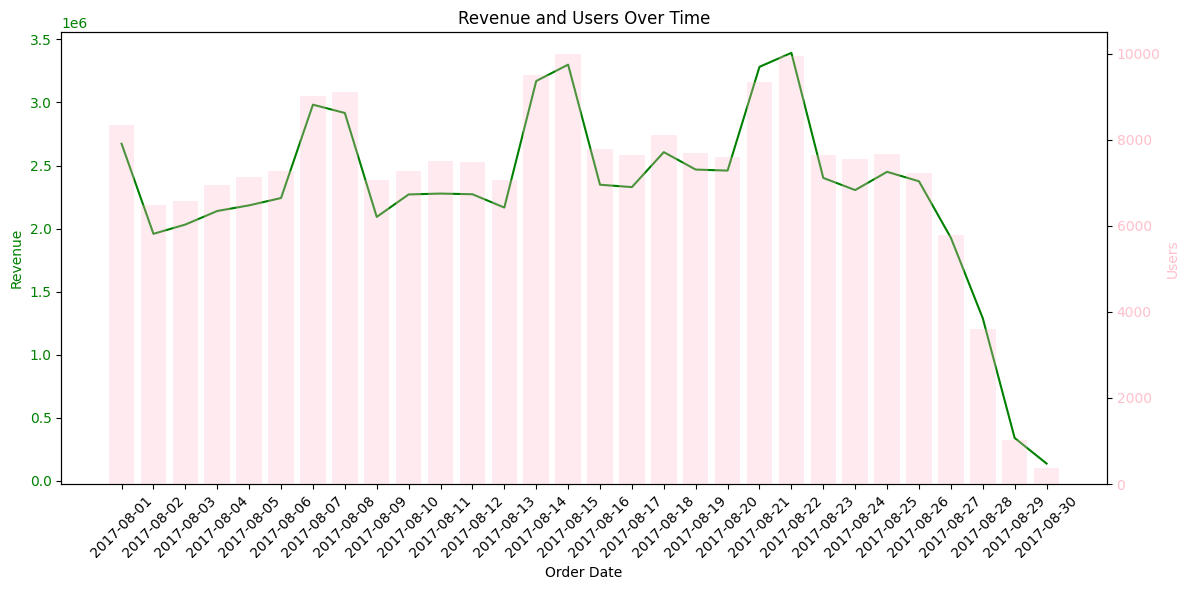

In [108]:
import pandas as pd
import matplotlib.pyplot as plt

df_revenue_viz = df_revenue.copy()

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(df_revenue_viz['order_date'], df_revenue_viz['revenue'], color='green', label='Revenue')
ax1.set_xlabel('Order Date')
ax1.set_ylabel('Revenue', color='green')
ax1.tick_params(axis='y', labelcolor='green')

ax1.grid(False)

plt.xticks(rotation=45)

ax2 = ax1.twinx()
ax2.bar(df_revenue_viz['order_date'], df_revenue_viz['users'], alpha=0.3, color='pink', label='Users')
ax2.set_ylabel('Users', color='pink')
ax2.tick_params(axis='y', labelcolor='pink')

ax2.grid(False)

plt.title('Revenue and Users Over Time')
fig.tight_layout()
plt.show()


In [109]:
df_revenue_city = df.groupby(['order_date','city'], as_index= False).agg({'total':'sum','user_id':'nunique'}).round(2)\
.rename(columns = {'total':'revenue','user_id':'users'})

In [110]:
df_revenue_city

,order_date,city,revenue,users
0,2017-08-01,Москва,1073374.50,3209
1,2017-08-01,Санкт-Петербург,1599783.75,5132
2,2017-08-02,Москва,793413.00,2584
3,2017-08-02,Санкт-Петербург,1164957.75,3908
4,2017-08-03,Москва,777094.50,2508
5,2017-08-03,Санкт-Петербург,1255014.00,4078
6,2017-08-04,Москва,837186.75,2702
7,2017-08-04,Санкт-Петербург,1302272.25,4251
8,2017-08-05,Москва,903001.50,2836
9,2017-08-05,Санкт-Петербург,1281291.75,4300


<ipython-input-111-3058c304c9e9>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(cities))


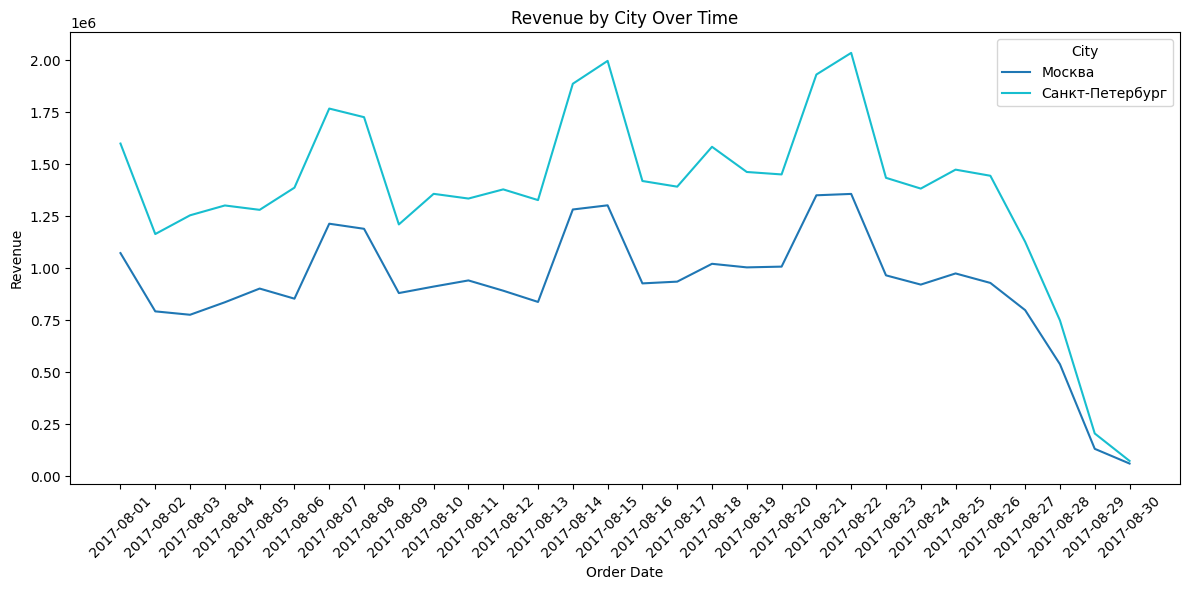

In [111]:
import pandas as pd
import matplotlib.pyplot as plt

df_revenue_city_viz = df_revenue_city.copy()

cities = df_revenue_city_viz['city'].unique()
colors = plt.cm.get_cmap('tab10', len(cities))

fig, ax = plt.subplots(figsize=(12, 6))

for i, city in enumerate(cities):
    city_data = df_revenue_city_viz[df_revenue_city_viz['city'] == city]
    ax.plot(city_data['order_date'], city_data['revenue'], label=city, color=colors(i))

plt.xticks(rotation=45)

ax.set_xlabel('Order Date')
ax.set_ylabel('Revenue')
ax.set_title('Revenue by City Over Time')

ax.grid(False)

ax.legend(title='City')

fig.tight_layout()

plt.show()

In [112]:
df_revenue_city.groupby('order_date', as_index=False).agg({'revenue':'sum','users':'sum'})

,order_date,revenue,users
0,2017-08-01,2673158.25,8341
1,2017-08-02,1958370.75,6492
2,2017-08-03,2032108.50,6586
3,2017-08-04,2139459.00,6953
4,2017-08-05,2184293.25,7136
5,2017-08-06,2242283.25,7286
6,2017-08-07,2982573.00,9031
7,2017-08-08,2916723.75,9124
8,2017-08-09,2092586.25,7075
9,2017-08-10,2270733.75,7273


Данные по кол-во пользователей не сходятся

In [113]:
city_uniq = df.groupby(['order_date','user_id'], as_index = False)\
.agg({'city':'nunique'})

In [114]:
city_uniq[city_uniq.city>1]

,order_date,user_id,city
1260,2017-08-01,41061,2
1439,2017-08-01,48183,2
1961,2017-08-01,70223,2
2325,2017-08-01,85997,2
3174,2017-08-01,139570,2
...,...,...,...
206341,2017-08-27,78026,2
209646,2017-08-27,297860,2
210401,2017-08-27,318658,2
210719,2017-08-27,1498510,2


In [115]:
df[(df.order_date == '2017-08-01')&(df.user_id == 41061)]

,order_date,order_id,warehouse_id,user_id,product_id,price,quantity,total,city,address
9626,2017-08-01,902803,396,41061,928,45.00,1,45.00,Санкт-Петербург,"Лермонтова, ул. 4"
9627,2017-08-01,902803,396,41061,12288,51.75,1,51.75,Санкт-Петербург,"Лермонтова, ул. 4"
10549,2017-08-01,916673,334,41061,5925,42.75,1,42.75,Москва,"Шоссейная, ул. 7"
10550,2017-08-01,916673,334,41061,12288,51.75,2,103.50,Москва,"Шоссейная, ул. 7"


Странно, что в один день с одного аккаунта есть заказы в разных городах. Поэтому происходит что данные не сходились.

In [116]:
df

,order_date,order_id,warehouse_id,user_id,product_id,price,quantity,total,city,address
0,2017-08-01,910381,38,11473,5570,44.25,1,44.25,Санкт-Петербург,"Комсомольская, ул. 10"
1,2017-08-01,918510,276,52410,9845,54.00,1,54.00,Москва,"Сосновая, ул. 21"
2,2017-08-01,918510,276,52410,19071,44.25,1,44.25,Москва,"Сосновая, ул. 21"
3,2017-08-01,909015,208,10155,451,83.25,1,83.25,Санкт-Петербург,"Подгорная, ул. 23"
4,2017-08-01,915064,2,60635,1054,69.75,1,69.75,Санкт-Петербург,"Молодежная, ул. 14"
...,...,...,...,...,...,...,...,...,...,...
975152,2017-08-30,1144129,109,318142,1708,104.25,1,104.25,Москва,"Железнодорожная, ул. 26"
975153,2017-08-30,1144129,109,318142,2870,21.75,5,108.75,Москва,"Железнодорожная, ул. 26"
975154,2017-08-30,1144129,109,318142,4861,31.50,1,31.50,Москва,"Железнодорожная, ул. 26"
975155,2017-08-30,1144129,109,318142,5570,32.25,1,32.25,Москва,"Железнодорожная, ул. 26"


In [117]:
df_revenue_city['arppu'] = (df_revenue_city['revenue']/df_revenue_city['users']).round(2)

In [118]:
df_revenue_city.head()

,order_date,city,revenue,users,arppu
0,2017-08-01,Москва,1073374.50,3209,334.49
1,2017-08-01,Санкт-Петербург,1599783.75,5132,311.73
2,2017-08-02,Москва,793413.00,2584,307.05
3,2017-08-02,Санкт-Петербург,1164957.75,3908,298.10
4,2017-08-03,Москва,777094.50,2508,309.85


In [119]:
true_orders = df.groupby(['order_date','user_id','order_id'], as_index = False).agg({'total':'sum'})

In [120]:
true_orders

,order_date,user_id,order_id,total
0,2017-08-01,2,924158,1146.75
1,2017-08-01,27,904066,89.25
2,2017-08-01,192,911337,201.00
3,2017-08-01,203,909400,511.50
4,2017-08-01,214,922006,100.50
...,...,...,...,...
240261,2017-08-30,1449387,1140841,150.75
240262,2017-08-30,1470046,1121321,98.25
240263,2017-08-30,1492355,1129556,309.75
240264,2017-08-30,1498370,1116945,479.25


In [121]:
true_orders['rank'] = true_orders.groupby('user_id')['order_date'].rank(method='dense', ascending=True)

In [122]:
first_day_offer = true_orders[true_orders['rank'] == 1]

In [123]:
first_day_offer.user_id.value_counts()

,count
user_id,
25270,9
85997,6
219660,6
197696,6
1223962,5
...,...
292984,1
293040,1
293053,1


In [124]:
first_day_offer[first_day_offer.user_id == 25270]

,order_date,user_id,order_id,total,rank
119761,2017-08-15,25270,1028489,51.75,1.0
119762,2017-08-15,25270,1028669,134.25,1.0
119763,2017-08-15,25270,1028729,66.75,1.0
119764,2017-08-15,25270,1030548,59.25,1.0
119765,2017-08-15,25270,1031912,216.75,1.0
119766,2017-08-15,25270,1036145,66.75,1.0
119767,2017-08-15,25270,1042207,111.75,1.0
119768,2017-08-15,25270,1051460,126.75,1.0
119769,2017-08-15,25270,1057708,66.75,1.0


In [125]:
first_day_revenue = first_day_offer.groupby('order_date', as_index=False).agg({'total':'sum','user_id':'nunique'})\
.rename(columns={'total':'revenue_new_users','user_id':'new_users'})

In [126]:
first_day_revenue.head()

,order_date,revenue_new_users,new_users
0,2017-08-01,2673158.25,8334
1,2017-08-02,1545690.00,5019
2,2017-08-03,1348609.50,4163
3,2017-08-04,1198947.00,3806
4,2017-08-05,1093719.75,3438


In [127]:
df_revenue.head()

,order_date,revenue,users,arppu
0,2017-08-01,2673158.25,8334,320.75
1,2017-08-02,1958370.75,6488,301.85
2,2017-08-03,2032108.50,6580,308.83
3,2017-08-04,2139459.00,6946,308.01
4,2017-08-05,2184293.25,7125,306.57


In [128]:
df_order_date_users = df_revenue.merge(first_day_revenue, how='left', on = 'order_date')

In [129]:
df_order_date_users['%_new_users'] = ((df_order_date_users['new_users']/df_order_date_users['users'])*100).round(1)

In [130]:
df_order_date_users

,order_date,revenue,users,arppu,revenue_new_users,new_users,%_new_users
0,2017-08-01,2673158.25,8334,320.75,2673158.25,8334,100.0
1,2017-08-02,1958370.75,6488,301.85,1545690.00,5019,77.4
2,2017-08-03,2032108.50,6580,308.83,1348609.50,4163,63.3
3,2017-08-04,2139459.00,6946,308.01,1198947.00,3806,54.8
4,2017-08-05,2184293.25,7125,306.57,1093719.75,3438,48.3
5,2017-08-06,2242283.25,7282,307.92,1015222.50,3210,44.1
6,2017-08-07,2982573.00,9018,330.74,1361732.25,4013,44.5
7,2017-08-08,2916723.75,9118,319.89,1260317.25,3691,40.5
8,2017-08-09,2092586.25,7073,295.86,665619.00,2286,32.3
9,2017-08-10,2270733.75,7266,312.51,648614.25,2145,29.5


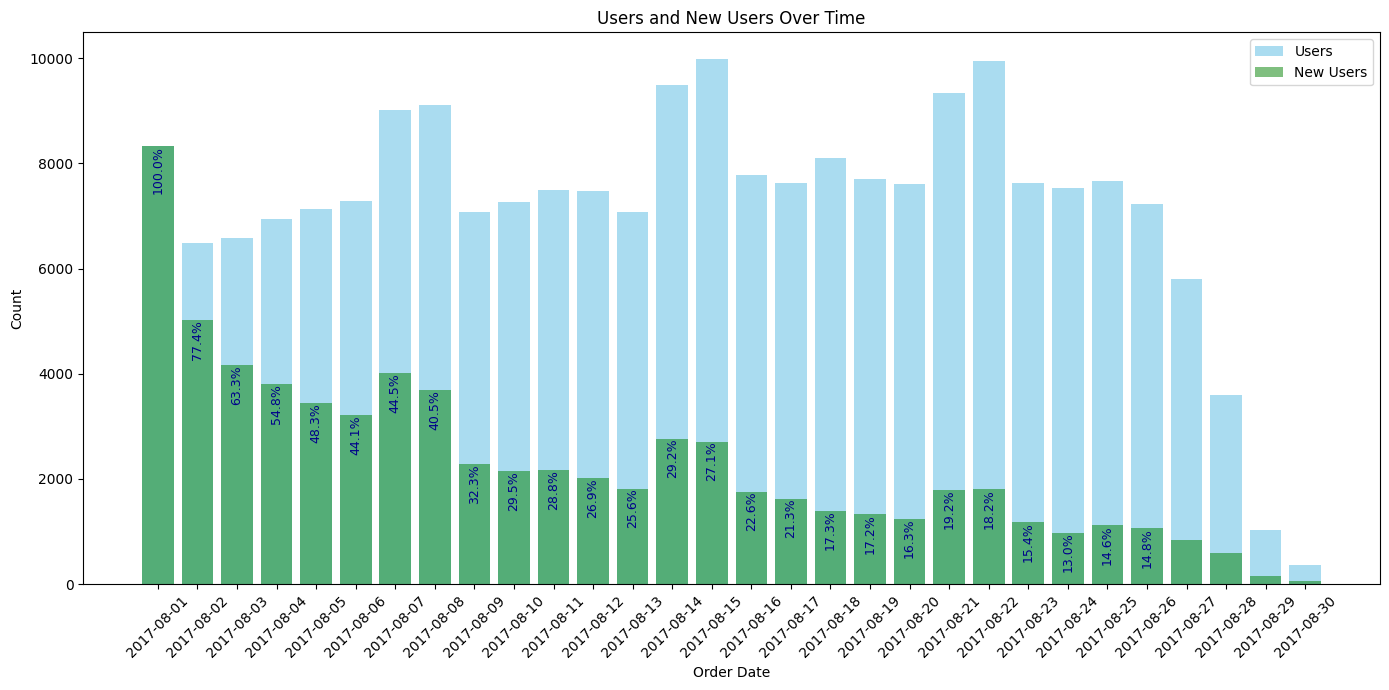

In [131]:
import pandas as pd
import matplotlib.pyplot as plt

df_order_date_users_viz = df_order_date_users.copy()

plt.figure(figsize=(14, 7))

plt.bar(df_order_date_users_viz['order_date'], df_order_date_users_viz['users'], color='skyblue', label='Users', alpha=0.7)

plt.bar(df_order_date_users_viz['order_date'], df_order_date_users_viz['new_users'], color='green', label='New Users', alpha=0.5)

for i, row in df_order_date_users_viz.iterrows():
  if row['new_users'] > 900:
    plt.text(row['order_date'], row['new_users'],
             f"{row['%_new_users']:.1f}%", ha='center',va ='top', color='darkblue', fontsize=9, rotation=90)

plt.xlabel('Order Date')
plt.ylabel('Count')
plt.title('Users and New Users Over Time')
plt.xticks(rotation=45)

plt.grid(False)

plt.legend()

plt.tight_layout()
plt.show()

In [132]:
n_first_day_offer = true_orders[true_orders['rank'] != 1]

In [133]:
n_first_day_offer.groupby('order_date', as_index=False).agg({'total':'sum','user_id':'nunique'}).round(2)

,order_date,total,user_id
0,2017-08-02,412680.75,1469
1,2017-08-03,683499.00,2417
2,2017-08-04,940512.00,3140
3,2017-08-05,1090573.50,3687
4,2017-08-06,1227060.75,4072
5,2017-08-07,1620840.75,5005
6,2017-08-08,1656406.50,5427
7,2017-08-09,1426967.25,4787
8,2017-08-10,1622119.50,5121
9,2017-08-11,1620369.00,5335


In [134]:
df_to = true_orders.groupby('user_id', as_index=False).agg({'order_date':'nunique'})

In [135]:
df_to.order_date.value_counts()

,count
order_date,
1,30494
2,11352
3,7025
4,4674
5,3549
6,2673
7,2011
8,1540
9,1183


In [136]:
true_orders

,order_date,user_id,order_id,total,rank
0,2017-08-01,2,924158,1146.75,1.0
1,2017-08-01,27,904066,89.25,1.0
2,2017-08-01,192,911337,201.00,1.0
3,2017-08-01,203,909400,511.50,1.0
4,2017-08-01,214,922006,100.50,1.0
...,...,...,...,...,...
240261,2017-08-30,1449387,1140841,150.75,11.0
240262,2017-08-30,1470046,1121321,98.25,15.0
240263,2017-08-30,1492355,1129556,309.75,1.0
240264,2017-08-30,1498370,1116945,479.25,4.0


In [137]:
true_orders['order_date'] = pd.to_datetime(true_orders['order_date'])

Хочу узнать для каждого пользователя сколько максимально дней подряд он делал заказ

In [138]:
df_long_day_orders = true_orders.groupby('user_id')['order_date'].apply(lambda x: x.diff().dt.days.ne(1).cumsum().value_counts().max()).reset_index()

In [154]:
df_long_day_orders

,user_id,order_date
0,0,1
1,2,2
2,3,1
3,4,2
4,12,1
...,...,...
68503,1701161,1
68504,1797115,3
68505,1828671,3
68506,1844946,1


Пойдет разбивка по неделям, дням недели

In [139]:
true_orders['weekday'] = true_orders['order_date'].dt.weekday
true_orders['weekday_name'] = true_orders['order_date'].dt.day_name()
true_orders['week_number'] = true_orders['order_date'].dt.isocalendar().week

In [140]:
true_orders.groupby('week_number', as_index=False).agg({'order_id':'count','total':'sum'}).round(2)

,week_number,order_id,total
0,31,47423,13229673.00
1,32,60496,16979316.75
2,33,65401,18680724.75
3,34,61813,18135202.36
4,35,5133,1765550.96


In [141]:
true_orders.groupby(['week_number','weekday','weekday_name'], as_index= False).agg({'order_id':'count','total':'sum'}).round(2).sort_values(by=[
    'week_number','weekday'])

,week_number,weekday,weekday_name,order_id,total
0,31,1,Tuesday,9328,2673158.25
1,31,2,Wednesday,7177,1958370.75
2,31,3,Thursday,7271,2032108.50
3,31,4,Friday,7658,2139459.00
4,31,5,Saturday,7876,2184293.25
5,31,6,Sunday,8113,2242283.25
6,32,0,Monday,10028,2982573.00
7,32,1,Tuesday,10151,2916723.75
8,32,2,Wednesday,7842,2092586.25
9,32,3,Thursday,8091,2270733.75


In [142]:
df_by_weekdays = true_orders.groupby(['weekday','weekday_name'], as_index= False).agg({'order_id':'count','total':'sum'})\
.round(2).sort_values(by='weekday')\
.rename(columns = {'order_id':'orders','total':'revenue'})

In [143]:
df_by_weekdays

,weekday,weekday_name,orders,revenue
0,0,Monday,35053,10724564.21
1,1,Tuesday,43068,12622749.75
2,2,Wednesday,32620,8937171.75
3,3,Thursday,32302,8937239.25
4,4,Friday,33621,9473256.86
5,5,Saturday,32898,9299604.59
6,6,Sunday,30704,8795881.42


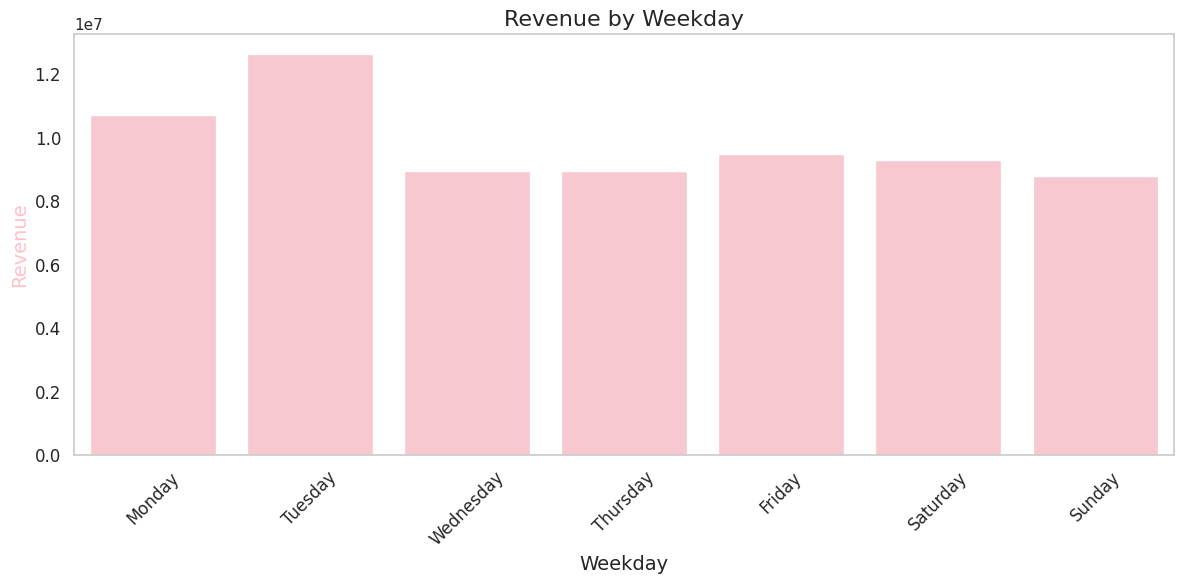

In [144]:
df_by_weekdays_viz = df_by_weekdays.copy()

sns.set(style="whitegrid")

fig, ax = plt.subplots(figsize=(12, 6))

sns.barplot(x='weekday_name', y='revenue', data=df_by_weekdays_viz, color='pink', ax=ax)

ax.set_xlabel('Weekday', fontsize=14)
ax.set_ylabel('Revenue', fontsize=14, color='pink')
ax.set_title('Revenue by Weekday', fontsize=16)
ax.tick_params(axis='x', rotation=45, labelsize=12)
ax.tick_params(axis='y', labelsize=12)

ax.grid(False)

fig.tight_layout()

plt.show()

In [145]:
true_orders

,order_date,user_id,order_id,total,rank,weekday,weekday_name,week_number
0,2017-08-01,2,924158,1146.75,1.0,1,Tuesday,31
1,2017-08-01,27,904066,89.25,1.0,1,Tuesday,31
2,2017-08-01,192,911337,201.00,1.0,1,Tuesday,31
3,2017-08-01,203,909400,511.50,1.0,1,Tuesday,31
4,2017-08-01,214,922006,100.50,1.0,1,Tuesday,31
...,...,...,...,...,...,...,...,...
240261,2017-08-30,1449387,1140841,150.75,11.0,2,Wednesday,35
240262,2017-08-30,1470046,1121321,98.25,15.0,2,Wednesday,35
240263,2017-08-30,1492355,1129556,309.75,1.0,2,Wednesday,35
240264,2017-08-30,1498370,1116945,479.25,4.0,2,Wednesday,35


In [146]:
def weekday(day_number):
    if day_number >= 0 and day_number <= 4:
        return "будни"
    elif day_number >= 5 and day_number <= 6:
        return "выходные"

In [147]:
true_orders['weekday_category'] = true_orders['weekday'].apply(weekday)

In [148]:
true_orders.groupby('weekday_category', as_index=False).agg({'order_id':'count','total':'sum'}).round(2)

,weekday_category,order_id,total
0,будни,176664,50694981.83
1,выходные,63602,18095486.00


In [149]:
df_wn_wc = true_orders.groupby(['week_number','weekday_category'], as_index=False).agg({'order_id':'count','total':'sum'}).round(2)

In [150]:
df_wn_wc['total_wc_prev'] = df_wn_wc.groupby('weekday_category')['total'].shift()

In [151]:
df_wn_wc

,week_number,weekday_category,order_id,total,total_wc_prev
0,31,будни,31434,8803096.50,NaN
1,31,выходные,15989,4426576.50,NaN
2,32,будни,44438,12540199.50,8803096.50
3,32,выходные,16058,4439117.25,4426576.50
4,33,будни,48229,13752939.75,12540199.50
5,33,выходные,17172,4927785.00,4439117.25
6,34,будни,47430,13833195.11,13752939.75
7,34,выходные,14383,4302007.25,4927785.00
8,35,будни,5133,1765550.96,13833195.11


In [152]:
df_wn_wc['difference_percent'] = ((df_wn_wc['total'] - df_wn_wc['total_wc_prev']) / df_wn_wc['total_wc_prev']) * 100

In [153]:
df_wn_wc

,week_number,weekday_category,order_id,total,total_wc_prev,difference_percent
0,31,будни,31434,8803096.50,NaN,NaN
1,31,выходные,15989,4426576.50,NaN,NaN
2,32,будни,44438,12540199.50,8803096.50,42.452142
3,32,выходные,16058,4439117.25,4426576.50,0.283306
4,33,будни,48229,13752939.75,12540199.50,9.670821
5,33,выходные,17172,4927785.00,4439117.25,11.008219
6,34,будни,47430,13833195.11,13752939.75,0.583551
7,34,выходные,14383,4302007.25,4927785.00,-12.698966
8,35,будни,5133,1765550.96,13833195.11,-87.236853
